In [1]:
# From: https://www.kaggle.com/c/dog-breed-identification/data
# Author: Morpheus Hsieh

from __future__ import print_function, division

# import os, sys
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import join
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms, utils

In [2]:
RawPath = r'D:\GitWork\dog_breed\data\raw'
print("Raw path: '{}'".format(RawPath))

ProcPath = r'D:\GitWork\dog_breed\data\processed'
print("Processed path: '{}'".format(ProcPath))

fname_breeds_dict = 'breeds_processed.csv'
fname_labels_proc = 'labels_processed.csv'

BatchSize = 6
NUM_BREED_CLASSES = 16
FRAC_FOR_TRAIN = 0.8

Phase = ['train', 'valid']

npz_files = {
    'train': 'train_data.npz',
    'valid': 'valid_data.npz'
}

npz_columns = ['images', 'labels']

LoadPreModel = True
ResultPath = r'D:\GitWork\dog_breed\results'
PreTrainedModel = 'resnet18-5c106cde.pth'

Raw path: 'D:\GitWork\dog_breed\data\raw'
Processed path: 'D:\GitWork\dog_breed\data\processed'


In [3]:
# Load most popular 16 breeds and breed ids
csv_breeds = join(ProcPath, fname_breeds_dict)
df_breeds = pd.read_csv(csv_breeds)
print(df_breeds.info());
print(df_breeds.head())

selected_breed_list = list(df_breeds['breed'][:NUM_BREED_CLASSES])
print('\nSelected breeds:', len(selected_breed_list))
print(selected_breed_list)

selected_bid_list = list(df_breeds['breed_id'][:NUM_BREED_CLASSES])
print('\nSelected breed ids:', len(selected_breed_list))
print(selected_bid_list)

# Create breed dict
df_breed_selected = df_breeds[df_breeds['breed'].isin(selected_breed_list)]
print('\nBreeds Selected:')
print(df_breeds.info());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   breed_id  120 non-null    int64 
 1   breed     120 non-null    object
 2   count     120 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ KB
None
   breed_id                 breed  count
0         0    scottish_deerhound    126
1         1           maltese_dog    117
2         2          afghan_hound    116
3         3           entlebucher    115
4         4  bernese_mountain_dog    114

Selected breeds: 16
['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian', 'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg', 'cairn', 'beagle', 'japanese_spaniel']

Selected breed ids: 16
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Breeds Selected:
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [4]:
def df2dict(df, clock='fw'):
    dic = {}
    for i, row in df.iterrows():
        if clock == 'fw':
            dic[row['breed']] = row['breed_id']
        elif clock == 'bw':
            key = str(row['breed_id'])
            dic[key] = row['breed']
    return dic

breed_dic_fw = df2dict(df_breed_selected)
print('Breed dic (fw):')
print(json.dumps(breed_dic_fw, indent=4))

breed_dic_bw = df2dict(df_breed_selected, 'bw')
print('\nBreed dic (bw):')
print(json.dumps(breed_dic_bw, indent=4))

Breed dic (fw):
{
    "scottish_deerhound": 0,
    "maltese_dog": 1,
    "afghan_hound": 2,
    "entlebucher": 3,
    "bernese_mountain_dog": 4,
    "shih-tzu": 5,
    "great_pyrenees": 6,
    "pomeranian": 7,
    "basenji": 8,
    "samoyed": 9,
    "airedale": 10,
    "tibetan_terrier": 11,
    "leonberg": 12,
    "cairn": 13,
    "beagle": 14,
    "japanese_spaniel": 15
}

Breed dic (bw):
{
    "0": "scottish_deerhound",
    "1": "maltese_dog",
    "2": "afghan_hound",
    "3": "entlebucher",
    "4": "bernese_mountain_dog",
    "5": "shih-tzu",
    "6": "great_pyrenees",
    "7": "pomeranian",
    "8": "basenji",
    "9": "samoyed",
    "10": "airedale",
    "11": "tibetan_terrier",
    "12": "leonberg",
    "13": "cairn",
    "14": "beagle",
    "15": "japanese_spaniel"
}


In [5]:
# Filter labels data accoring to selected breeds
csv_labels = join(ProcPath, fname_labels_proc)
df_labels  = pd.read_csv(csv_labels)
train_data = df_labels[df_labels['breed_id'].isin(selected_bid_list)]
print(train_data)

img_list = list(train_data['image'])
lbl_list = list(train_data['breed_id'])

data_rows = len(train_data)
print('\nTotal rows:', data_rows)

train_len = int(float(FRAC_FOR_TRAIN) * float(data_rows))
print('Train len :', train_len)
print('Valid len :', data_rows - train_len)

train_imgs = img_list[:train_len]
train_lbls = lbl_list[:train_len]
print(len(train_imgs), len(train_lbls))

valid_imgs = img_list[train_len:]
valid_lbls = lbl_list[train_len:]
print(len(valid_imgs), len(valid_lbls))

data = [
    [train_imgs, train_lbls],
    [valid_imgs, valid_lbls]
]

# Save data as npz file
for i in range(len(Phase)):
    args = { npz_columns[0]: data[i][0], npz_columns[1]: data[i][1] }
    fname = npz_files[Phase[i]]
    out_fname = join(ProcPath, fname)
    np.savez(out_fname, **args)

                                                   image  breed_id
8      D:\GitWork\dog_breed\data\raw\train\003df8b8a8...         8
9      D:\GitWork\dog_breed\data\raw\train\0042188c89...         0
12     D:\GitWork\dog_breed\data\raw\train\00693b8bc2...         1
29     D:\GitWork\dog_breed\data\raw\train\00bee065dc...        13
48     D:\GitWork\dog_breed\data\raw\train\013f8fdf6d...        11
...                                                  ...       ...
10207  D:\GitWork\dog_breed\data\raw\train\ffa4e1bf95...         8
10212  D:\GitWork\dog_breed\data\raw\train\ffc532991d...        11
10215  D:\GitWork\dog_breed\data\raw\train\ffcde16e7d...        10
10216  D:\GitWork\dog_breed\data\raw\train\ffcffab7e4...         9
10219  D:\GitWork\dog_breed\data\raw\train\ffe2ca6c94...        10

[1777 rows x 2 columns]

Total rows: 1777
Train len : 1421
Valid len : 356
1421 1421
356 356


In [6]:
# Normalize
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

class myDataset(Dataset):
    
    npzFiles = { 
        'train': 'train_data.npz', 
        'valid': 'valid_data.npz' 
    }

    def __init__(self, path, phase='train', transform=None):
        npz_fname = self.npzFiles[phase]
        data = np.load(join(path, npz_fname), allow_pickle=True)
        self.images = data['images']
        self.labels = data['labels']

        self.transform = transform
        self.len = len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        img_pil = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img_pil)

        lbl = int(self.labels[index])
        
        return [img, lbl]

    def __len__(self):
        return self.len

    
trainSet = myDataset(ProcPath, transform=transform)
validSet = myDataset(ProcPath, phase='valid', transform=transform)
print('\nTrainSet size: ', len(trainSet))
print('ValidSet size: ', len(validSet))

trainLoader = DataLoader(trainSet, batch_size=BatchSize, shuffle=True)
validLoader = DataLoader(validSet, batch_size=BatchSize, shuffle=False)
print('\nTrainLoader size: ', len(trainLoader))
print('ValidLoader size: ', len(validLoader))

trainSize = len(trainSet)
validSize = len(validSet)

imgs, lbls = next(iter(trainLoader))
print('\nImage type:', type(imgs))
print('      size: ', imgs.size())

print('\nLabel type:', type(lbls))
print('      size: ', lbls.size())

img = imgs[0]
print('\nImage shape:', img.shape)
print(); print(img)

lbl = lbls[0]
print('\nLabel shape:', lbl)


TrainSet size:  1421
ValidSet size:  356

TrainLoader size:  237
ValidLoader size:  60

Image type: <class 'torch.Tensor'>
      size:  torch.Size([6, 3, 224, 224])

Label type: <class 'torch.Tensor'>
      size:  torch.Size([6])

Image shape: torch.Size([3, 224, 224])

tensor([[[ 1.6838,  1.7009,  1.6667,  ..., -1.0219, -1.0904, -1.0904],
         [ 1.6667,  1.7009,  1.6838,  ..., -1.0219, -1.0390, -1.0219],
         [ 1.6495,  1.7009,  1.7009,  ..., -0.9877, -1.0048, -0.9877],
         ...,
         [-0.0801, -0.0458, -0.0116,  ..., -0.1828, -0.2171, -0.2171],
         [-0.0801, -0.0287,  0.0056,  ..., -0.1999, -0.2171, -0.2171],
         [-0.0801, -0.0287,  0.0398,  ..., -0.1657, -0.1999, -0.2171]],

        [[ 1.5882,  1.6057,  1.5707,  ..., -1.3354, -1.3704, -1.3704],
         [ 1.5707,  1.6057,  1.5882,  ..., -1.3354, -1.3179, -1.3004],
         [ 1.5532,  1.6057,  1.6057,  ..., -1.3004, -1.3179, -1.3004],
         ...,
         [-0.4951, -0.4426, -0.3725,  ..., -0.6877, -0.6702

torch.Size([6, 3, 224, 224]) torch.Size([6])


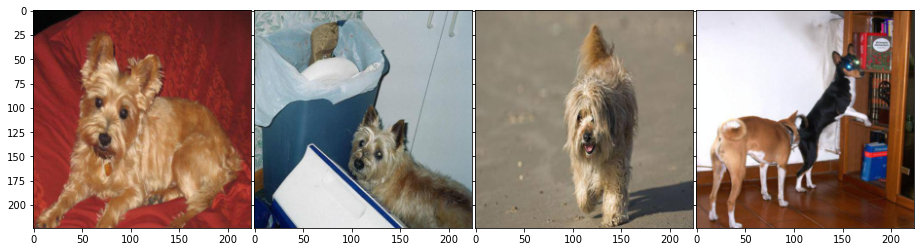

In [7]:
# Show image

def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # maxValue = np.amax(inp)
    # minValue = np.amin(inp)
    # print(maxValue, minValue)
   
    # All values were in between (0, 1.0000000236034394), 
    # so simply clipped the data
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)
    
    
img, label = next(iter(trainLoader))
print(img.size(), label.size())

fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(4):
    ax = grid[i]
    imshow(ax, img[i])

In [8]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        
        for phase in ['train', 'valid']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistic
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()                
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                  epoch, num_epochs - 1,
                  train_epoch_loss, train_epoch_acc, 
                  valid_epoch_loss, valid_epoch_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, best_acc

In [9]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [10]:
# Test model

# resnet = models.resnet50(pretrained=True)
# inputs, labels = next(iter(trainLoader))

# if use_gpu:
#     resnet = resnet.cuda()
#     inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
# else:
#     inputs, labels = Variable(inputs), Variable(labels)

# outputs = resnet(inputs)
# outputs.size()

In [11]:
model = models.resnet18(pretrained=True)
# resnet = models.resnet50(pretrained=True)


if LoadPreTrained:
    f_abspath = join(ModelPath, PreTrainedModel)
    pre_model_wts = torch.load(f_abspath)
    model.load_state_dict(pre_model_wts)

# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# new final layer with 16 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_BREED_CLASSES)

if use_gpu: model = model.cuda()
# model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataLoaders = { 'train':trainLoader, 'valid':validLoader }

In [12]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

In [13]:
start_time = time.time()
model, best_acc = train_model(dataLoaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/1] train loss: 0.2469 acc: 0.5876 valid loss: 0.0895 acc: 0.8596
Epoch [1/1] train loss: 0.1164 acc: 0.8227 valid loss: 0.0658 acc: 0.8680
Best val Acc: 0.867978
Training time:   0.453621 minutes


In [17]:
import datetime

currDT = datetime.datetime.now()
currStr = currDT.strftime("%Y%m%d-%H%M%S")

acc_str = int(best_acc * 100)

fname_trained_model = '{}_resnet18_acc{}.pth'.format(currStr, acc_str)

torch.save(model.state_dict(), join(ModelPath, fname_trained_model))

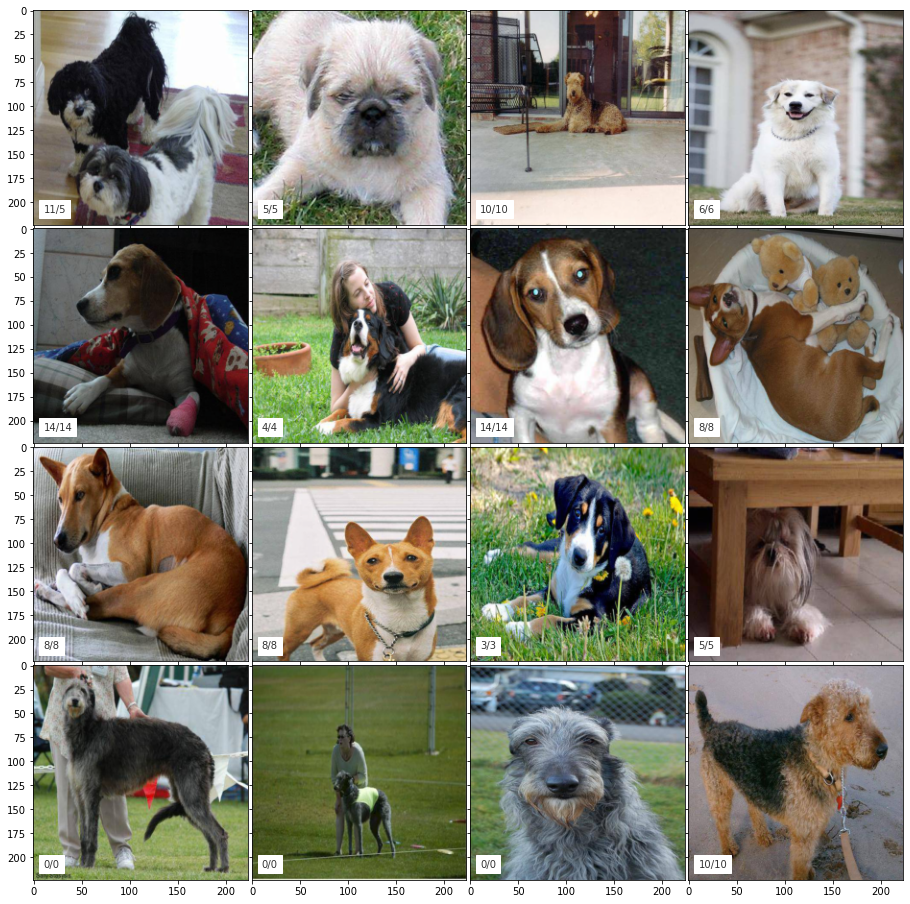

In [15]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return
            
visualize_model(dataLoaders, model)